In [117]:
import pandas as pd
import numpy as np
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [118]:
#   Загружаем данные с помощью pandas
data = pd.read_csv('NVDA.csv')
#data.info


In [119]:
#   Колонки которые нас интересуют
data = data[['Date', 'Close']]
#data.plot(figsize=(10,10))

In [175]:
#   Разделение данных на тестовые и тренеровочные
col = data.Close.astype('float32')
train = col[:int(len(col) * 0.8)]
scale_col = MinMaxScaler()
scale_col.fit(train.values.reshape(-1, 1))
col = scale_col.transform(col.values.reshape(-1, 1))
#print(col)

def xyarray(data, lb):
    "Распределим данные для X и Y чтобы угадывать каждый lb элемент"
    x = []
    y = []
    print(len(data) - lb - 1)
    for i in range(len(data) - lb - 1):
        x.append(data[i:(i + lb), 0])
        y.append(data[(i + lb), 0])
    return np.array(x), np.array(y)

lb = 10
x,y = xyarray(col, lb)
val = 0.9
x_train, x_test = x[:int(x.shape[0] * val)], x[int(x.shape[0] * val):]
y_train, y_test = y[:int(x.shape[0] * val)], y[int(x.shape[0] * val):]
print(x_train.shape[0], x_train.shape[1])
print(y_train.shape[0])
print(x_test.shape[0], x_test.shape[1])
print(y_test.shape[0])

5774
5196 10
5196
578 10
578


In [169]:
model = Sequential()
model.add(LSTM(128, input_shape = (lb, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [170]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test), shuffle=False, verbose = False)

163/163 [==============================] - 0s 1ms/step


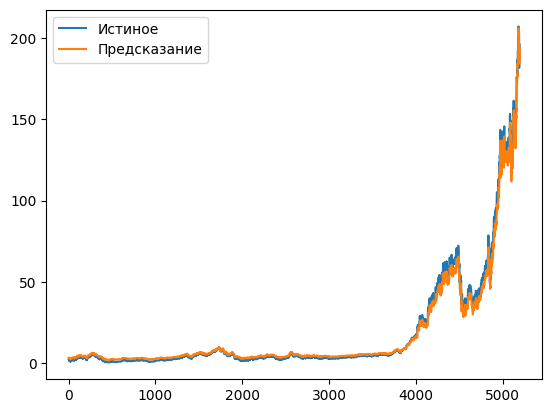

In [157]:
#Прогнозы

result_predict = model.predict(x_train)

plt.plot(scale_col.inverse_transform(y_train.reshape(-1, 1)), label = 'Истиное')
plt.plot(scale_col.inverse_transform(result_predict), label = 'Предсказание')
plt.legend()



19/19 [==============================] - 0s 1ms/step


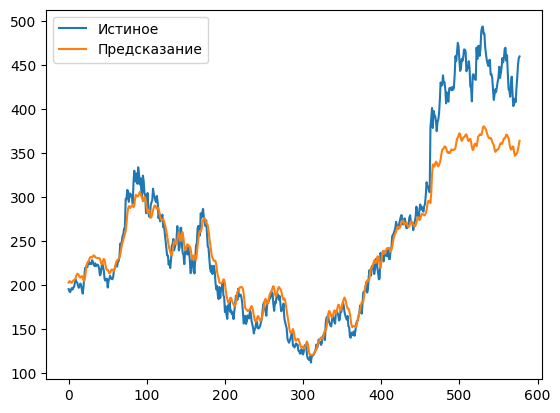

In [130]:
# тесты
result_predict = model.predict(x_test)

plt.plot(scale_col.inverse_transform(y_test.reshape(-1, 1)), label = 'Истиное')
plt.plot(scale_col.inverse_transform(result_predict), label = 'Предсказание')
plt.legend()


In [125]:
#немного изменим лог результатов эпох
class EpochEndCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"{epoch}\nРезультаты обучения на конец эпохи:", logs)

0
Результаты обучения на конец эпохи: {'loss': 0.0030464085284620523, 'val_loss': 1.7068407535552979}
1
Результаты обучения на конец эпохи: {'loss': 0.007810064125806093, 'val_loss': 0.81147700548172}
2
Результаты обучения на конец эпохи: {'loss': 0.002022139960899949, 'val_loss': 0.7030463814735413}
3
Результаты обучения на конец эпохи: {'loss': 0.0033202965278178453, 'val_loss': 0.4719031751155853}
4
Результаты обучения на конец эпохи: {'loss': 0.008662228472530842, 'val_loss': 1.0476963520050049}
5
Результаты обучения на конец эпохи: {'loss': 0.003714185208082199, 'val_loss': 0.42208045721054077}
6
Результаты обучения на конец эпохи: {'loss': 0.001308203674852848, 'val_loss': 0.3064906895160675}
7
Результаты обучения на конец эпохи: {'loss': 0.0008444138802587986, 'val_loss': 0.6123058199882507}
8
Результаты обучения на конец эпохи: {'loss': 0.0010819081217050552, 'val_loss': 0.392265260219574}
9
Результаты обучения на конец эпохи: {'loss': 0.002513604238629341, 'val_loss': 0.274928

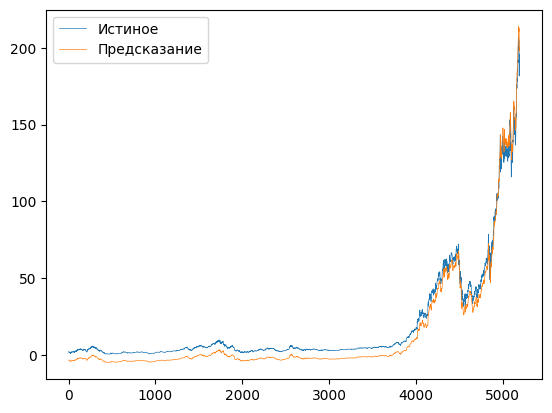

In [126]:

"Функция для n обучений"
# Рисуем "истинные" данные
plt.plot(figsize=(20,20))
plt.plot(scale_col.inverse_transform(y_train.reshape(-1, 1)), label = 'Истиное', linewidth = 0.5)
    


x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

#Засунем fit в переменную, в случае чего, можно будет использовать результат =)
history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), shuffle=False, callbacks=[EpochEndCallback()], verbose=False)

result_predict = model.predict(x_train)
plt.plot(scale_col.inverse_transform(result_predict), label = f'Предсказание', linewidth = 0.5)
plt.legend()


In [176]:
print(x_train.shape[:2])
print(y_test.shape)

(5196, 10)
(578,)


In [187]:
ensemble_model = VotingClassifier(estimators=[('model1', result_predict), ('model2', result_predict)], voting='hard')
print(ensemble_model)
results = cross_val_score(ensemble_model, x_train, y_train[0], cv=5)

VotingClassifier(estimators=[('model1',
                              array([[0.04042077],
       [0.04164773],
       [0.04178536],
       ...,
       [2.6123192 ],
       [2.5937662 ],
       [2.6836252 ]], dtype=float32)),
                             ('model2',
                              array([[0.04042077],
       [0.04164773],
       [0.04178536],
       ...,
       [2.6123192 ],
       [2.5937662 ],
       [2.6836252 ]], dtype=float32))])


InvalidParameterError: The 'y' parameter of cross_validate must be an array-like or None. Got 0.024839953 instead.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=100, n_features=1, noise=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestRegressor()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.legend()
plt.show()
